In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, Embedding, Masking
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras.utils import to_categorical

Using TensorFlow backend.


In [203]:
import copy

In [133]:
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
cwd = os.getcwd()
parent_wd = cwd.replace('/model', '')
training_set_path = parent_wd + '/preprocessing/training_seq_n'
dev_set_path = parent_wd + '/preprocessing/dev_seq_n'

In [5]:
with open(training_set_path, 'rb') as f:
    training_set = pickle.load(f)
with open(dev_set_path, 'rb') as f:
    dev_set = pickle.load(f)

In [6]:
X_train = training_set['X']
Y_train = training_set['Y']
X_dev = dev_set['X']
Y_dev = dev_set['Y']

In [185]:
dev_set['keys'][np.where(dev_set['tmax'] == 23)]

array(['308089'], dtype='<U6')

In [7]:
labels = ['V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13']

In [8]:
print(X_train.shape)
print(Y_train.shape)
print(X_dev.shape)
print(Y_dev.shape)

(24609, 23, 22)
(24609,)
(3000, 23, 22)
(3000,)


In [9]:
training_move_path = parent_wd + '/preprocessing/training_move_n'
dev_move_path = parent_wd + '/preprocessing/dev_move_n'

In [10]:
with open(training_move_path, 'rb') as f:
    training_set_move = pickle.load(f)
with open(dev_move_path, 'rb') as f:
    dev_set_move = pickle.load(f)

In [11]:
X_train_move = training_set_move['X']
Y_train_move = training_set_move['Y']
X_dev_move = dev_set_move['X']
Y_dev_move = dev_set_move['Y']

In [12]:
class_weight = {0: 1,
                1: 1,
                2: 3, 
                3: 3, 
                4: 3, 
                5: 5,
                6: 7, 
                7: 7, 
                8: 9, 
                9: 9}

### Model S1: deep RNN

In [13]:
models1 = Sequential()
models1.add(Masking(mask_value=0., input_shape = (23, 22)))
models1.add(LSTM(50, activation='relu', input_shape=(23, 22), kernel_initializer='glorot_normal', return_sequences = 'True'))
models1.add(LSTM(50, activation='relu', kernel_initializer='glorot_normal', return_sequences = 'True'))
models1.add(LSTM(40, activation='relu', kernel_initializer='glorot_normal', return_sequences = 'True'))
models1.add(LSTM(40, activation='relu', kernel_initializer='glorot_normal'))
models1.add(Dense(30, activation='relu', kernel_initializer='glorot_normal'))
models1.add(Dense(30, activation='relu', kernel_initializer='glorot_normal'))
models1.add(Dense(20, activation='relu', kernel_initializer='glorot_normal'))
models1.add(Dense(10, activation='softmax'))
models1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(models1.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 23, 22)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 23, 50)            14600     
_________________________________________________________________
lstm_10 (LSTM)               (None, 23, 50)            20200     
_________________________________________________________________
lstm_11 (LSTM)               (None, 23, 40)            14560     
_________________________________________________________________
lstm_12 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dense_9 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_10 (Dense)             (None, 30)               

In [18]:
historys1_all = []
np.random.seed(0)

In [19]:
for i in range(10):
    historys1 = models1.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data = (X_dev, Y_dev))
    historys1_all.append(historys1)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 43s 2ms/step - loss: 1.4127 - sparse_categorical_accuracy: 0.4269 - val_loss: 1.3048 - val_sparse_categorical_accuracy: 0.4733
Epoch 2/10
24609/24609 [==============================] - 38s 2ms/step - loss: 1.2688 - sparse_categorical_accuracy: 0.4687 - val_loss: 1.2487 - val_sparse_categorical_accuracy: 0.4787
Epoch 3/10
24609/24609 [==============================] - 39s 2ms/step - loss: 1.2450 - sparse_categorical_accuracy: 0.4747 - val_loss: 1.2605 - val_sparse_categorical_accuracy: 0.4727
Epoch 4/10
24609/24609 [==============================] - 39s 2ms/step - loss: 1.2356 - sparse_categorical_accuracy: 0.4782 - val_loss: 1.2315 - val_sparse_categorical_accuracy: 0.4850
Epoch 5/10
24609/24609 [==============================] - 40s 2ms/step - loss: 1.2292 - sparse_categorical_accuracy: 0.4839 - val_loss: 1.2680 - val_sparse_categorical_accuracy: 0.4790
Epoch 6/10
24609/24609 [==

KeyboardInterrupt: 

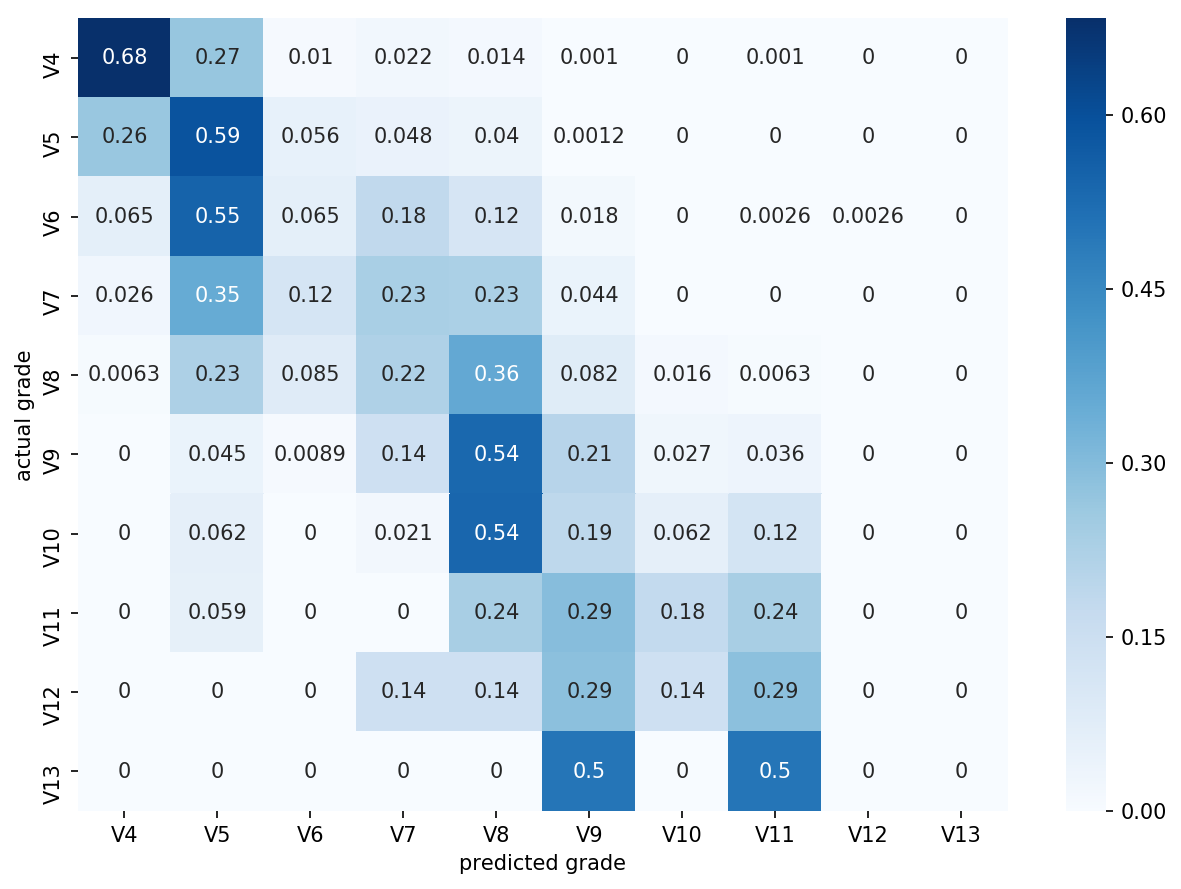

In [64]:
conf_matrix = confusion_matrix(Y_dev, models1.predict(X_dev).argmax(axis=1))
df_cm = pd.DataFrame((conf_matrix/np.sum(conf_matrix, axis = 1, keepdims = True)), 
                     index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(dpi = 150, figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('predicted grade')
plt.ylabel('actual grade')
plt.show()

### Model S1: deep LSTM + weighted input

In [75]:
for i in range(10):
    historys1 = models1.fit(X_train, Y_train, epochs=10, batch_size=32, validation_data = (X_dev, Y_dev), class_weight=class_weight)
    historys1_all.append(historys1)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 39s 2ms/step - loss: 2.4851 - sparse_categorical_accuracy: 0.5097 - val_loss: 1.4345 - val_sparse_categorical_accuracy: 0.4307
Epoch 2/10
24609/24609 [==============================] - 39s 2ms/step - loss: 2.3642 - sparse_categorical_accuracy: 0.5243 - val_loss: 1.5022 - val_sparse_categorical_accuracy: 0.4037
Epoch 3/10
24609/24609 [==============================] - 41s 2ms/step - loss: 2.3053 - sparse_categorical_accuracy: 0.5335 - val_loss: 1.4761 - val_sparse_categorical_accuracy: 0.4047
Epoch 4/10
24609/24609 [==============================] - 38s 2ms/step - loss: 2.2698 - sparse_categorical_accuracy: 0.5364 - val_loss: 1.4416 - val_sparse_categorical_accuracy: 0.4433
Epoch 5/10
24609/24609 [==============================] - 39s 2ms/step - loss: 2.2521 - sparse_categorical_accuracy: 0.5343 - val_loss: 1.4667 - val_sparse_categorical_accuracy: 0.4177
Epoch 6/10
24609/24609 [==

KeyboardInterrupt: 

### Model S2: adjust learning rate

In [79]:
models2 = Sequential()
models2.add(Masking(mask_value=0., input_shape = (23, 22)))
models2.add(LSTM(50, activation='relu', input_shape=(23, 22), kernel_initializer='glorot_normal', return_sequences = 'True'))
models2.add(LSTM(50, activation='relu', kernel_initializer='glorot_normal', return_sequences = 'True'))
models2.add(LSTM(40, activation='relu', kernel_initializer='glorot_normal', return_sequences = 'True'))
models2.add(LSTM(40, activation='relu', kernel_initializer='glorot_normal'))
models2.add(Dense(30, activation='relu', kernel_initializer='glorot_normal'))
models2.add(Dense(30, activation='relu', kernel_initializer='glorot_normal'))
models2.add(Dense(20, activation='relu', kernel_initializer='glorot_normal'))
models2.add(Dense(10, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
models2.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(models2.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_5 (Masking)          (None, 23, 22)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 23, 50)            14600     
_________________________________________________________________
lstm_18 (LSTM)               (None, 23, 50)            20200     
_________________________________________________________________
lstm_19 (LSTM)               (None, 23, 40)            14560     
_________________________________________________________________
lstm_20 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dense_27 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_28 (Dense)             (None, 30)               

In [80]:
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 3)
]

In [81]:
historys2_all = []
np.random.seed(0)

In [82]:
for i in range(10):
    historys2 = models2.fit(X_train, Y_train, epochs=10, callbacks = callbacks, batch_size=32, validation_data = (X_dev, Y_dev))
    historys2_all.append(historys2)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 44s 2ms/step - loss: 1.3475 - sparse_categorical_accuracy: 0.4436 - val_loss: 1.3646 - val_sparse_categorical_accuracy: 0.4390
Epoch 2/10
24609/24609 [==============================] - 41s 2ms/step - loss: 1.2821 - sparse_categorical_accuracy: 0.4666 - val_loss: 1.2589 - val_sparse_categorical_accuracy: 0.4753
Epoch 3/10
24609/24609 [==============================] - 43s 2ms/step - loss: 1.2605 - sparse_categorical_accuracy: 0.4700 - val_loss: 1.2997 - val_sparse_categorical_accuracy: 0.4633
Epoch 4/10
24609/24609 [==============================] - 38s 2ms/step - loss: 1.2538 - sparse_categorical_accuracy: 0.4721 - val_loss: 1.2375 - val_sparse_categorical_accuracy: 0.4903
Epoch 5/10
24609/24609 [==============================] - 37s 2ms/step - loss: 1.2461 - sparse_categorical_accuracy: 0.4755 - val_loss: 1.3021 - val_sparse_categorical_accuracy: 0.4537
Epoch 6/10
24609/24609 [==

### Model M1: NN

In [66]:
modelm1 = Sequential()
modelm1.add(Dense(50, activation='relu', input_shape=(22, ), kernel_initializer='glorot_normal'))
modelm1.add(Dense(40, activation='relu', kernel_initializer='glorot_normal'))
modelm1.add(Dense(30, activation='relu', kernel_initializer='glorot_normal'))
modelm1.add(Dense(20, activation='relu', kernel_initializer='glorot_normal'))
modelm1.add(Dense(10, activation='softmax'))
modelm1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(modelm1.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 50)                1150      
_________________________________________________________________
dense_19 (Dense)             (None, 40)                2040      
_________________________________________________________________
dense_20 (Dense)             (None, 30)                1230      
_________________________________________________________________
dense_21 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_22 (Dense)             (None, 10)                210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________
None


In [67]:
historym1_all = []
np.random.seed(0)

In [72]:
for i in range(10):
    historym1 = modelm1.fit(X_train_move, Y_train_move, epochs=10, batch_size=32, validation_data = (X_dev_move, Y_dev_move))
    historym1_all.append(historym1)

Train on 159725 samples, validate on 3000 samples
Epoch 1/10
159725/159725 [==============================] - 6s 35us/step - loss: 1.3887 - sparse_categorical_accuracy: 0.4363 - val_loss: 1.3805 - val_sparse_categorical_accuracy: 0.4407
Epoch 2/10
159725/159725 [==============================] - 6s 36us/step - loss: 1.3545 - sparse_categorical_accuracy: 0.4450 - val_loss: 1.3655 - val_sparse_categorical_accuracy: 0.4377
Epoch 3/10
159725/159725 [==============================] - 6s 35us/step - loss: 1.3467 - sparse_categorical_accuracy: 0.4480 - val_loss: 1.3613 - val_sparse_categorical_accuracy: 0.4367
Epoch 4/10
159725/159725 [==============================] - 5s 33us/step - loss: 1.3418 - sparse_categorical_accuracy: 0.4495 - val_loss: 1.3532 - val_sparse_categorical_accuracy: 0.4423
Epoch 5/10
159725/159725 [==============================] - 5s 33us/step - loss: 1.3375 - sparse_categorical_accuracy: 0.4513 - val_loss: 1.3526 - val_sparse_categorical_accuracy: 0.4463
Epoch 6/10
1597

KeyboardInterrupt: 

### Model M2: larger NN

In [13]:
modelm2 = Sequential()
modelm2.add(Dense(100, activation='relu', input_shape=(22, ), kernel_initializer='glorot_normal'))
modelm2.add(Dense(80, activation='relu', kernel_initializer='glorot_normal'))
modelm2.add(Dense(60, activation='relu', kernel_initializer='glorot_normal'))
modelm2.add(Dense(30, activation='relu', kernel_initializer='glorot_normal'))
modelm2.add(Dense(10, activation='softmax'))
modelm2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(modelm2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               2300      
_________________________________________________________________
dense_2 (Dense)              (None, 80)                8080      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                4860      
_________________________________________________________________
dense_4 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                310       
Total params: 17,380
Trainable params: 17,380
Non-trainable params: 0
_________________________________________________________________
None


In [14]:
historym2_all = []
np.random.seed(0)

In [15]:
for i in range(10):
    historym2 = modelm2.fit(X_train_move, Y_train_move, epochs=10, batch_size=32, validation_data = (X_dev_move, Y_dev_move))
    historym2_all.append(historym2)

Train on 159725 samples, validate on 3000 samples
Epoch 1/10
159725/159725 [==============================] - 6s 40us/step - loss: 1.3812 - sparse_categorical_accuracy: 0.4368 - val_loss: 1.3736 - val_sparse_categorical_accuracy: 0.4397
Epoch 2/10
159725/159725 [==============================] - 6s 35us/step - loss: 1.3514 - sparse_categorical_accuracy: 0.4456 - val_loss: 1.3606 - val_sparse_categorical_accuracy: 0.4367
Epoch 3/10
159725/159725 [==============================] - 6s 35us/step - loss: 1.3416 - sparse_categorical_accuracy: 0.4502 - val_loss: 1.3533 - val_sparse_categorical_accuracy: 0.4410
Epoch 4/10
159725/159725 [==============================] - 6s 36us/step - loss: 1.3348 - sparse_categorical_accuracy: 0.4520 - val_loss: 1.3501 - val_sparse_categorical_accuracy: 0.4440
Epoch 5/10
159725/159725 [==============================] - 6s 36us/step - loss: 1.3292 - sparse_categorical_accuracy: 0.4542 - val_loss: 1.3515 - val_sparse_categorical_accuracy: 0.4483
Epoch 6/10
1597

KeyboardInterrupt: 

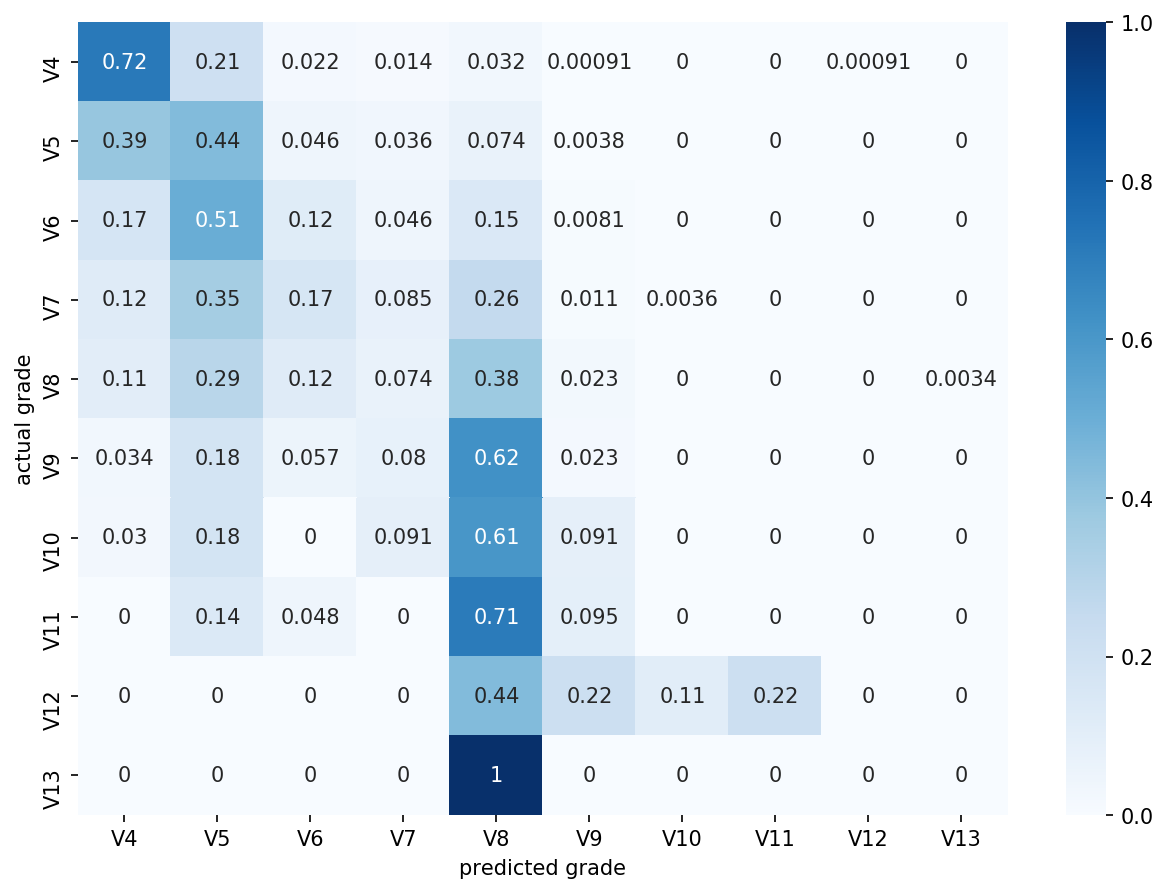

In [16]:
conf_matrix = confusion_matrix(Y_dev_move, modelm2.predict(X_dev_move).argmax(axis=1))
df_cm = pd.DataFrame((conf_matrix/np.sum(conf_matrix, axis = 1, keepdims = True)), 
                     index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(dpi = 150, figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('predicted grade')
plt.ylabel('actual grade')
plt.show()

In [22]:
layer_output=modelm2.get_layer('dense_4').output
intermediate_model = keras.models.Model(inputs=modelm2.input, outputs=layer_output)

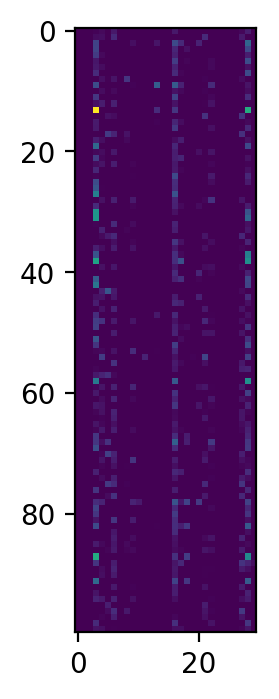

In [41]:
plt.figure(dpi = 200)
plt.imshow(intermediate_model.predict(X_dev_move[400:500, :]))

### Model M3: larger NN + dropout

In [42]:
modelm3 = Sequential()
modelm3.add(Dense(100, activation='relu', input_shape=(22, ), kernel_initializer='glorot_normal'))
modelm3.add(Dropout(0.5))
modelm3.add(Dense(80, activation='relu', kernel_initializer='glorot_normal'))
modelm3.add(Dropout(0.4))
modelm3.add(Dense(60, activation='relu', kernel_initializer='glorot_normal'))
modelm3.add(Dropout(0.4))
modelm3.add(Dense(30, activation='relu', kernel_initializer='glorot_normal'))
modelm3.add(Dropout(0.3))
modelm3.add(Dense(10, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
modelm3.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(modelm3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               2300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 80)                8080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 60)                4860      
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 30)               

In [43]:
historym3_all = []
np.random.seed(0)

In [44]:
for i in range(10):
    historym3 = modelm3.fit(X_train_move, Y_train_move, epochs=10, batch_size=32, validation_data = (X_dev_move, Y_dev_move))
    historym3_all.append(historym3)

Train on 159725 samples, validate on 3000 samples
Epoch 1/10
159725/159725 [==============================] - 8s 51us/step - loss: 1.5074 - sparse_categorical_accuracy: 0.3942 - val_loss: 1.4531 - val_sparse_categorical_accuracy: 0.4103
Epoch 2/10
159725/159725 [==============================] - 8s 51us/step - loss: 1.5119 - sparse_categorical_accuracy: 0.3940 - val_loss: 1.4663 - val_sparse_categorical_accuracy: 0.4033- sparse_categorical_ac
Epoch 3/10
159725/159725 [==============================] - 7s 45us/step - loss: 1.5224 - sparse_categorical_accuracy: 0.3970 - val_loss: 1.5071 - val_sparse_categorical_accuracy: 0.4100
Epoch 4/10
159725/159725 [==============================] - 8s 51us/step - loss: 1.5470 - sparse_categorical_accuracy: 0.3930 - val_loss: 1.5263 - val_sparse_categorical_accuracy: 0.4010
Epoch 5/10
159725/159725 [==============================] - 8s 51us/step - loss: 1.5497 - sparse_categorical_accuracy: 0.3880 - val_loss: 1.5239 - val_sparse_categorical_accuracy:

### Model M4  remove score

In [53]:
modelm4 = Sequential()
modelm4.add(Dense(200, activation='relu', input_shape=(21, ), kernel_initializer='glorot_normal'))
modelm4.add(Dense(80, activation='relu', kernel_initializer='glorot_normal'))
modelm4.add(Dense(60, activation='relu', kernel_initializer='glorot_normal'))
modelm4.add(Dense(30, activation='relu', kernel_initializer='glorot_normal'))
modelm4.add(Dense(10, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
modelm4.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(modelm4.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               4400      
_________________________________________________________________
dense_17 (Dense)             (None, 80)                16080     
_________________________________________________________________
dense_18 (Dense)             (None, 60)                4860      
_________________________________________________________________
dense_19 (Dense)             (None, 30)                1830      
_________________________________________________________________
dense_20 (Dense)             (None, 10)                310       
Total params: 27,480
Trainable params: 27,480
Non-trainable params: 0
_________________________________________________________________
None


In [54]:
historym4_all = []
np.random.seed(0)

In [56]:
for i in range(10):
    historym4 = modelm4.fit(X_train_move[:, 0:21], Y_train_move, epochs=10, batch_size=128, validation_data = (X_dev_move[:, 0:21], Y_dev_move))
    historym4_all.append(historym4)

Train on 159725 samples, validate on 3000 samples
Epoch 1/10
159725/159725 [==============================] - 2s 15us/step - loss: 1.3915 - sparse_categorical_accuracy: 0.4347 - val_loss: 1.3838 - val_sparse_categorical_accuracy: 0.4400
Epoch 2/10
159725/159725 [==============================] - 2s 12us/step - loss: 1.3611 - sparse_categorical_accuracy: 0.4437 - val_loss: 1.3747 - val_sparse_categorical_accuracy: 0.4417
Epoch 3/10
159725/159725 [==============================] - 2s 15us/step - loss: 1.3538 - sparse_categorical_accuracy: 0.4452 - val_loss: 1.3654 - val_sparse_categorical_accuracy: 0.4400
Epoch 4/10
159725/159725 [==============================] - 2s 13us/step - loss: 1.3487 - sparse_categorical_accuracy: 0.4457 - val_loss: 1.3685 - val_sparse_categorical_accuracy: 0.4413
Epoch 5/10
159725/159725 [==============================] - 2s 14us/step - loss: 1.3460 - sparse_categorical_accuracy: 0.4482 - val_loss: 1.3634 - val_sparse_categorical_accuracy: 0.4427
Epoch 6/10
1597

In [57]:
for i in range(50):
    historym4 = modelm4.fit(X_train_move[:, 0:21], Y_train_move, epochs=10, batch_size=128, validation_data = (X_dev_move[:, 0:21], Y_dev_move))
    historym4_all.append(historym4)

Train on 159725 samples, validate on 3000 samples
Epoch 1/10
159725/159725 [==============================] - 2s 13us/step - loss: 1.2989 - sparse_categorical_accuracy: 0.4648 - val_loss: 1.3666 - val_sparse_categorical_accuracy: 0.4417
Epoch 2/10
159725/159725 [==============================] - 2s 14us/step - loss: 1.2999 - sparse_categorical_accuracy: 0.4650 - val_loss: 1.3666 - val_sparse_categorical_accuracy: 0.4493
Epoch 3/10
159725/159725 [==============================] - 2s 15us/step - loss: 1.2989 - sparse_categorical_accuracy: 0.4643 - val_loss: 1.3507 - val_sparse_categorical_accuracy: 0.4520
Epoch 4/10
159725/159725 [==============================] - 2s 13us/step - loss: 1.2985 - sparse_categorical_accuracy: 0.4651 - val_loss: 1.3656 - val_sparse_categorical_accuracy: 0.4507
Epoch 5/10
159725/159725 [==============================] - 2s 14us/step - loss: 1.2964 - sparse_categorical_accuracy: 0.4653 - val_loss: 1.3555 - val_sparse_categorical_accuracy: 0.4487
Epoch 6/10
1597

### Model M5: converge all greater than V8 as V8

In [212]:
modelm5 = Sequential()
modelm5.add(Dense(200, activation='relu', input_shape=(22, ), kernel_initializer='glorot_normal'))
modelm5.add(Dense(80, activation='relu', kernel_initializer='glorot_normal'))
modelm5.add(Dense(60, activation='relu', kernel_initializer='glorot_normal'))
modelm5.add(Dense(30, activation='relu', kernel_initializer='glorot_normal'))
modelm5.add(Dense(5, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
modelm5.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(modelm5.summary())

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 200)               4600      
_________________________________________________________________
dense_212 (Dense)            (None, 80)                16080     
_________________________________________________________________
dense_213 (Dense)            (None, 60)                4860      
_________________________________________________________________
dense_214 (Dense)            (None, 30)                1830      
_________________________________________________________________
dense_215 (Dense)            (None, 5)                 155       
Total params: 27,525
Trainable params: 27,525
Non-trainable params: 0
_________________________________________________________________
None


In [205]:
X_train_move_sim = copy.deepcopy(X_train_move)
Y_train_move_sim = copy.deepcopy(Y_train_move)
X_dev_move_sim = copy.deepcopy(X_dev_move)
Y_dev_move_sim = copy.deepcopy(Y_dev_move)

In [208]:
Y_train_move_sim[Y_train_move_sim > 4] = 4
Y_dev_move_sim[Y_dev_move_sim > 4] = 4

In [210]:
historym5_all = []
np.random.seed(0)

In [213]:
for i in range(10):
    historym5 = modelm5.fit(X_train_move_sim, Y_train_move_sim, epochs=10, batch_size=128, validation_data = (X_dev_move_sim, Y_dev_move_sim))
    historym5_all.append(historym5)

Train on 159725 samples, validate on 3000 samples
Epoch 1/10
159725/159725 [==============================] - 3s 18us/step - loss: 1.2456 - sparse_categorical_accuracy: 0.4722 - val_loss: 1.2430 - val_sparse_categorical_accuracy: 0.4637
Epoch 2/10
159725/159725 [==============================] - 3s 16us/step - loss: 1.2250 - sparse_categorical_accuracy: 0.4805 - val_loss: 1.2394 - val_sparse_categorical_accuracy: 0.4857
Epoch 3/10
159725/159725 [==============================] - 2s 14us/step - loss: 1.2188 - sparse_categorical_accuracy: 0.4829 - val_loss: 1.2266 - val_sparse_categorical_accuracy: 0.4887
Epoch 4/10
159725/159725 [==============================] - 2s 14us/step - loss: 1.2147 - sparse_categorical_accuracy: 0.4841 - val_loss: 1.2160 - val_sparse_categorical_accuracy: 0.4960
Epoch 5/10
159725/159725 [==============================] - 3s 16us/step - loss: 1.2119 - sparse_categorical_accuracy: 0.4852 - val_loss: 1.2165 - val_sparse_categorical_accuracy: 0.4843
Epoch 6/10
1597

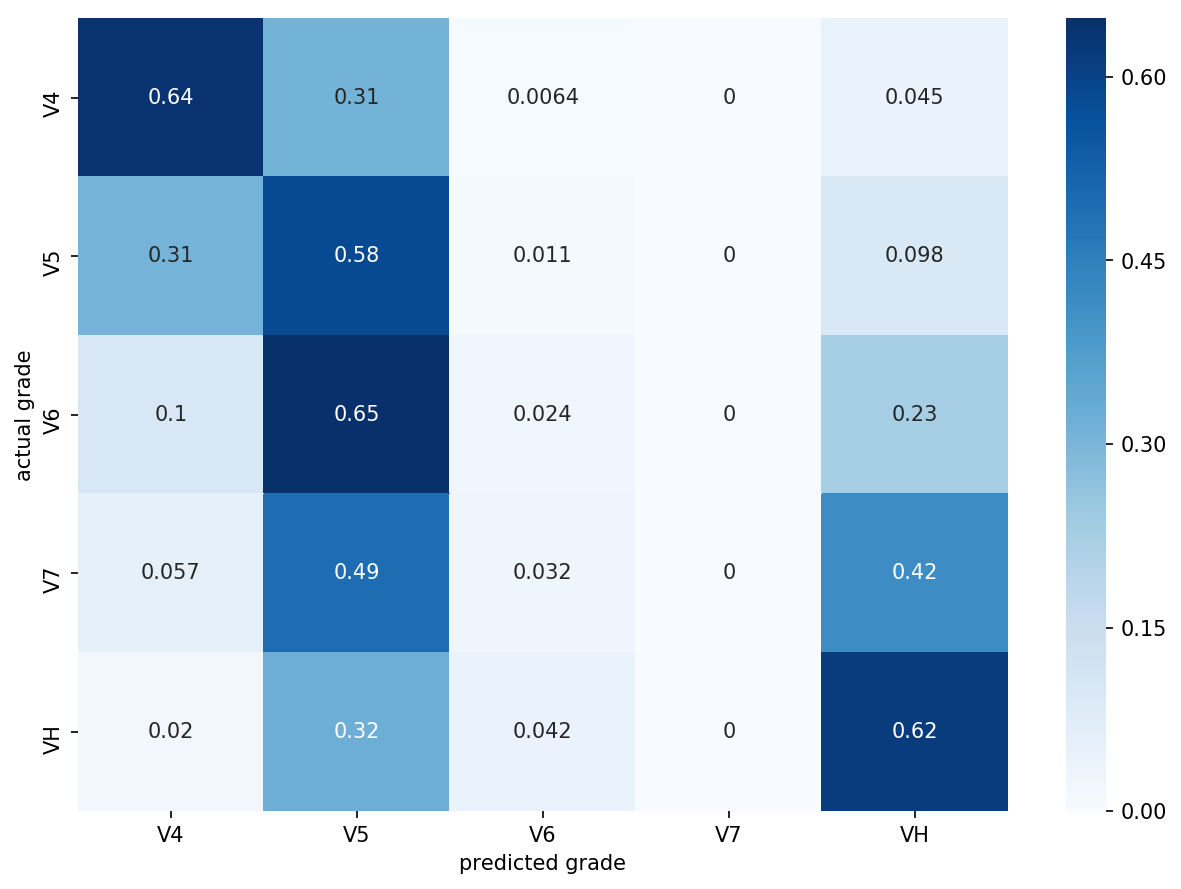

In [216]:
conf_matrix = confusion_matrix(Y_dev_move_sim, modelm5.predict(X_dev_move_sim).argmax(axis=1))
df_cm = pd.DataFrame((conf_matrix/np.sum(conf_matrix, axis = 1, keepdims = True)), 
                     index = [i for i in ['V4', 'V5', 'V6', 'V7', 'VH']],
                     columns = [i for i in ['V4', 'V5', 'V6', 'V7', 'VH']])
plt.figure(dpi = 150, figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('predicted grade')
plt.ylabel('actual grade')
plt.show()

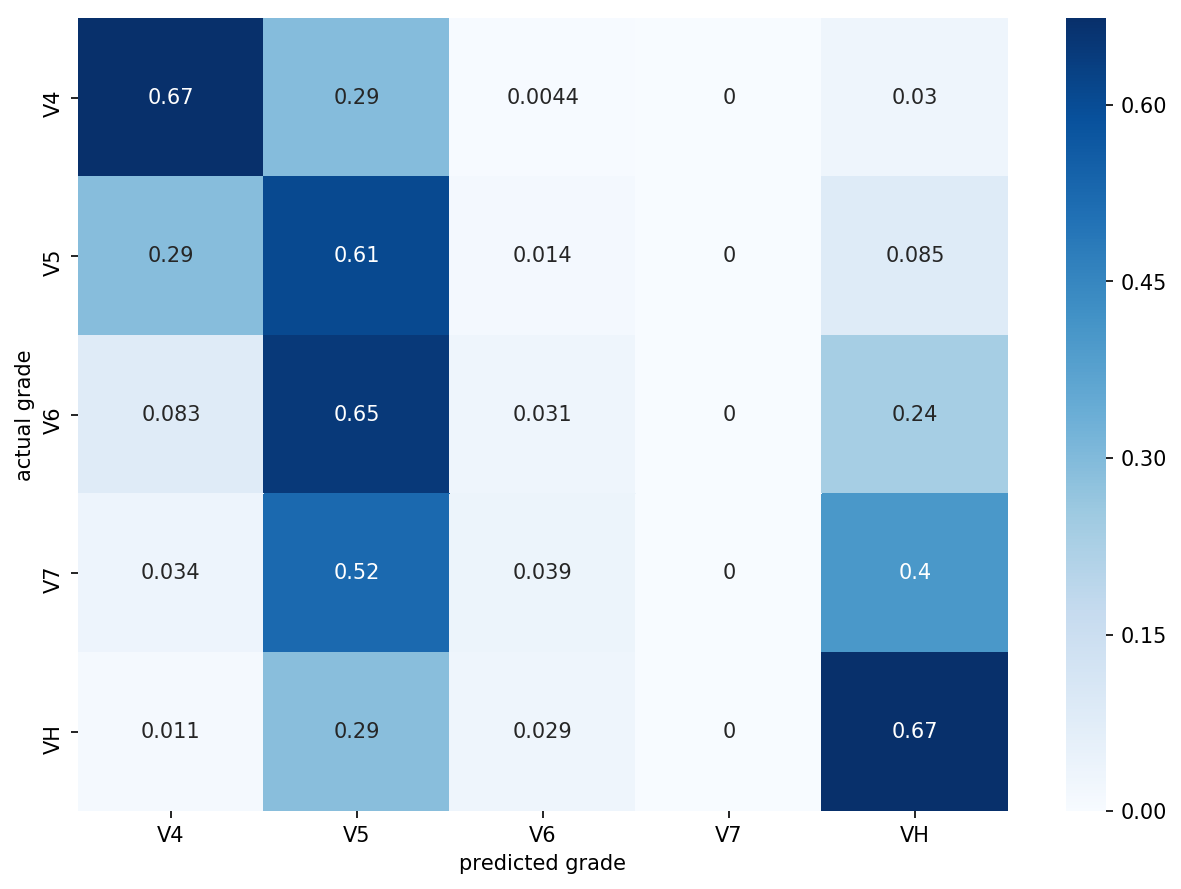

In [217]:
conf_matrix = confusion_matrix(Y_train_move_sim, modelm5.predict(X_train_move_sim).argmax(axis=1))
df_cm = pd.DataFrame((conf_matrix/np.sum(conf_matrix, axis = 1, keepdims = True)), 
                     index = [i for i in ['V4', 'V5', 'V6', 'V7', 'VH']],
                     columns = [i for i in ['V4', 'V5', 'V6', 'V7', 'VH']])
plt.figure(dpi = 150, figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('predicted grade')
plt.ylabel('actual grade')
plt.show()

### Model M6: easy, moderate, difficult moves

In [232]:
X_train_move_3lev = copy.deepcopy(X_train_move)
Y_train_move_3lev = copy.deepcopy(Y_train_move)
X_dev_move_3lev = copy.deepcopy(X_dev_move)
Y_dev_move_3lev = copy.deepcopy(Y_dev_move)

In [233]:
Y_train_move_3lev[Y_train_move <= 1] = 0
Y_dev_move_3lev[Y_dev_move <= 1] = 0

In [261]:
Y_train_move_3lev[(Y_train_move == 2) + (Y_train_move == 3)] = 1
Y_dev_move_3lev[(Y_dev_move == 2) + (Y_dev_move == 3)] = 1

In [235]:
Y_train_move_3lev[Y_train_move >= 4] = 2
Y_dev_move_3lev[Y_dev_move >= 4] = 2

In [236]:
modelm6 = Sequential()
modelm6.add(Dense(100, activation='relu', input_shape=(22, ), kernel_initializer='glorot_normal'))
modelm6.add(Dense(75, activation='relu', kernel_initializer='glorot_normal'))
modelm6.add(Dense(50, activation='relu', kernel_initializer='glorot_normal'))
modelm6.add(Dense(20, activation='relu', kernel_initializer='glorot_normal'))
modelm6.add(Dense(3, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
modelm6.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(modelm6.summary())

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_221 (Dense)            (None, 100)               2300      
_________________________________________________________________
dense_222 (Dense)            (None, 75)                7575      
_________________________________________________________________
dense_223 (Dense)            (None, 50)                3800      
_________________________________________________________________
dense_224 (Dense)            (None, 20)                1020      
_________________________________________________________________
dense_225 (Dense)            (None, 3)                 63        
Total params: 14,758
Trainable params: 14,758
Non-trainable params: 0
_________________________________________________________________
None


In [237]:
historym6_all = []
np.random.seed(0)

In [238]:
for i in range(10):
    historym6 = modelm6.fit(X_train_move_3lev, Y_train_move_3lev, 
                            epochs=10, batch_size=128, 
                            validation_data = (X_dev_move_3lev, Y_dev_move_3lev), 
                            class_weight = {0: 1, 1: 2, 2: 4})
    historym6_all.append(historym6)

Train on 159725 samples, validate on 3000 samples
Epoch 1/10
159725/159725 [==============================] - 3s 18us/step - loss: 1.4053 - sparse_categorical_accuracy: 0.6308 - val_loss: 0.8321 - val_sparse_categorical_accuracy: 0.6650
Epoch 2/10
159725/159725 [==============================] - 3s 16us/step - loss: 1.3703 - sparse_categorical_accuracy: 0.6353 - val_loss: 0.8123 - val_sparse_categorical_accuracy: 0.6630
Epoch 3/10
159725/159725 [==============================] - 3s 16us/step - loss: 1.3622 - sparse_categorical_accuracy: 0.6385 - val_loss: 0.8143 - val_sparse_categorical_accuracy: 0.6390
Epoch 4/10
159725/159725 [==============================] - 3s 16us/step - loss: 1.3555 - sparse_categorical_accuracy: 0.6409 - val_loss: 0.9008 - val_sparse_categorical_accuracy: 0.6517
Epoch 5/10
159725/159725 [==============================] - 3s 17us/step - loss: 1.3518 - sparse_categorical_accuracy: 0.6434 - val_loss: 0.8617 - val_sparse_categorical_accuracy: 0.6667
Epoch 6/10
1597

In [252]:
for i in range(50):
    historym6 = modelm6.fit(X_train_move_3lev, Y_train_move_3lev, 
                            epochs=10, batch_size=128, 
                            validation_data = (X_dev_move_3lev, Y_dev_move_3lev), 
                            class_weight = {0: 1, 1: 2, 2: 4})
    historym6_all.append(historym6)

Train on 159725 samples, validate on 3000 samples
Epoch 1/10
159725/159725 [==============================] - 3s 21us/step - loss: 1.2690 - sparse_categorical_accuracy: 0.6705 - val_loss: 0.9279 - val_sparse_categorical_accuracy: 0.6540
Epoch 2/10
159725/159725 [==============================] - 3s 18us/step - loss: 1.2698 - sparse_categorical_accuracy: 0.6699 - val_loss: 0.8431 - val_sparse_categorical_accuracy: 0.6770
Epoch 3/10
159725/159725 [==============================] - 3s 18us/step - loss: 1.2710 - sparse_categorical_accuracy: 0.6697 - val_loss: 0.8235 - val_sparse_categorical_accuracy: 0.6973
Epoch 4/10
159725/159725 [==============================] - 3s 20us/step - loss: 1.2754 - sparse_categorical_accuracy: 0.6710 - val_loss: 0.9016 - val_sparse_categorical_accuracy: 0.6777
Epoch 5/10
159725/159725 [==============================] - 3s 21us/step - loss: 1.2729 - sparse_categorical_accuracy: 0.6686 - val_loss: 0.9044 - val_sparse_categorical_accuracy: 0.64371.2593 - spa
Epo

KeyboardInterrupt: 

In [259]:
np.sum(Y_dev_move == 2)

372

In [260]:
np.sum(Y_dev_move_3lev == 1)

0

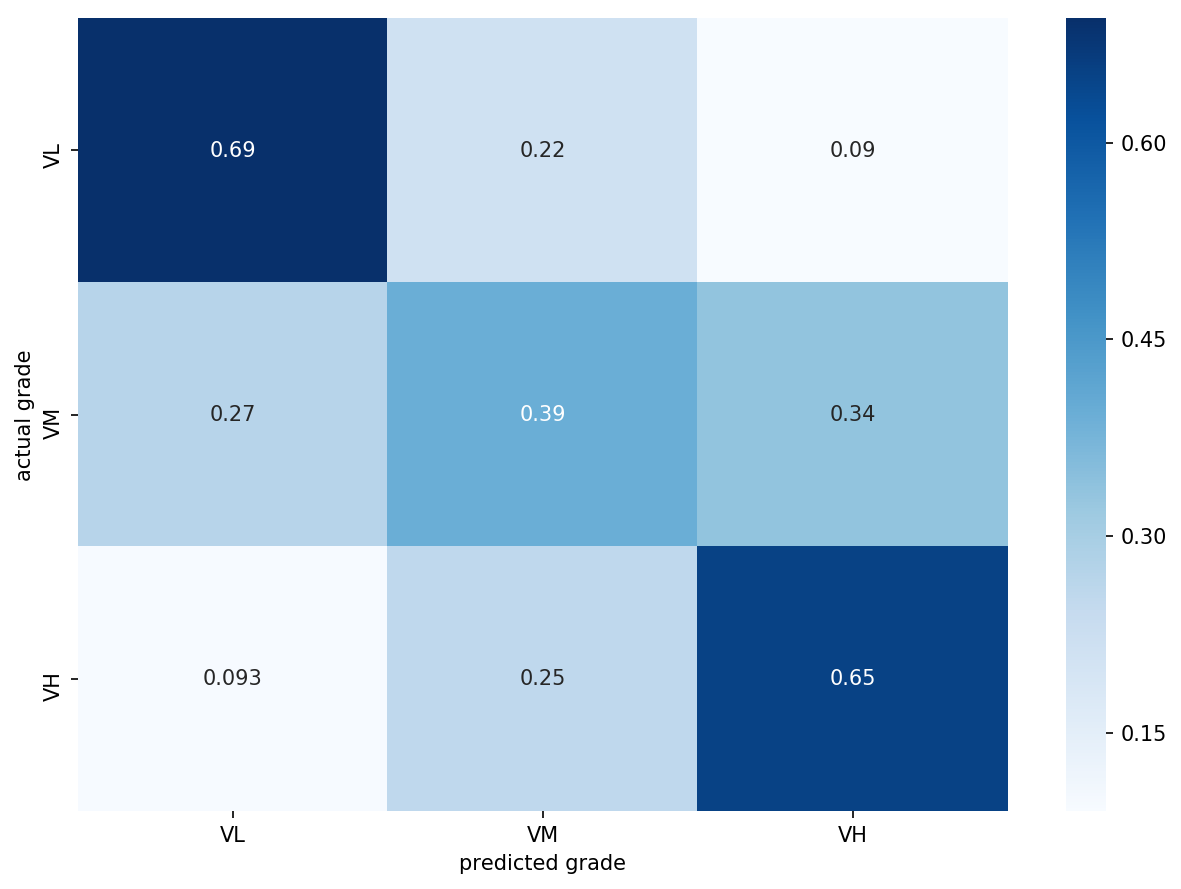

In [262]:
conf_matrix = confusion_matrix(Y_dev_move_3lev, modelm6.predict(X_dev_move_3lev).argmax(axis=1))
df_cm = pd.DataFrame((conf_matrix/np.sum(conf_matrix, axis = 1, keepdims = True)), 
                     index = [i for i in ['VL', 'VM', 'VH']],
                     columns = [i for i in ['VL', 'VM', 'VH']])
plt.figure(dpi = 150, figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('predicted grade')
plt.ylabel('actual grade')
plt.show()

### Process sequence data with Model M6

In [251]:
X_dev.shape

(3000, 23, 22)

### Model S3: dense layer before LSTM

In [59]:
models3 = Sequential()
models3.add(Masking(mask_value=0., input_shape = (23, 22)))
models3.add(Dense(22, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models3.add(LSTM(50, activation='relu', input_shape=(23, 22), kernel_initializer='glorot_normal'))
models3.add(Dense(10, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
models3.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(models3.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_2 (Masking)          (None, 23, 22)            0         
_________________________________________________________________
dense_23 (Dense)             (None, 23, 22)            506       
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                14600     
_________________________________________________________________
dense_24 (Dense)             (None, 10)                510       
Total params: 15,616
Trainable params: 15,616
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
historys3_all = []
np.random.seed(0)

In [62]:
for i in range(10):
    historys3 = models3.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data = (X_dev, Y_dev))
    historys3_all.append(historys3)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 6s 243us/step - loss: 1.3968 - sparse_categorical_accuracy: 0.4318 - val_loss: 1.2862 - val_sparse_categorical_accuracy: 0.4797
Epoch 2/10
24609/24609 [==============================] - 5s 200us/step - loss: 1.2648 - sparse_categorical_accuracy: 0.4715 - val_loss: 1.2572 - val_sparse_categorical_accuracy: 0.4797
Epoch 3/10
24609/24609 [==============================] - 5s 190us/step - loss: 1.2487 - sparse_categorical_accuracy: 0.4756 - val_loss: 1.2424 - val_sparse_categorical_accuracy: 0.4883
Epoch 4/10
24609/24609 [==============================] - 5s 206us/step - loss: 1.2417 - sparse_categorical_accuracy: 0.4771 - val_loss: 1.2525 - val_sparse_categorical_accuracy: 0.4877
Epoch 5/10
24609/24609 [==============================] - 5s 213us/step - loss: 1.2329 - sparse_categorical_accuracy: 0.4797 - val_loss: 1.2323 - val_sparse_categorical_accuracy: 0.4857
Epoch 6/10
24609/2460

In [72]:
for i in range(10):
    historys3 = models3.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data = (X_dev, Y_dev))
    historys3_all.append(historys3)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 5s 214us/step - loss: 1.0713 - sparse_categorical_accuracy: 0.5541 - val_loss: 1.4515 - val_sparse_categorical_accuracy: 0.4533
Epoch 2/10
24609/24609 [==============================] - 5s 197us/step - loss: 1.1449 - sparse_categorical_accuracy: 0.5179 - val_loss: 1.3815 - val_sparse_categorical_accuracy: 0.4627
Epoch 3/10
24609/24609 [==============================] - 5s 197us/step - loss: 1.1039 - sparse_categorical_accuracy: 0.5424 - val_loss: 1.7663 - val_sparse_categorical_accuracy: 0.4140
Epoch 4/10
24609/24609 [==============================] - 5s 205us/step - loss: 1.3100 - sparse_categorical_accuracy: 0.4653 - val_loss: 1.2863 - val_sparse_categorical_accuracy: 0.4767
Epoch 5/10
24609/24609 [==============================] - 5s 219us/step - loss: 1.2334 - sparse_categorical_accuracy: 0.4809 - val_loss: 1.2861 - val_sparse_categorical_accuracy: 0.4727
Epoch 6/10
24609/2460

KeyboardInterrupt: 

### model S4: dense layer before and after LSTM

In [73]:
models4 = Sequential()
models4.add(Masking(mask_value=0., input_shape = (23, 22)))
models4.add(Dense(50, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models4.add(Dense(50, activation='relu', input_shape = (23, 50), kernel_initializer='glorot_normal'))
models4.add(Dense(50, activation='relu', input_shape = (23, 50), kernel_initializer='glorot_normal'))
models4.add(Dense(50, activation='relu', input_shape = (23, 50), kernel_initializer='glorot_normal'))
models4.add(Dense(50, activation='relu', input_shape = (23, 50), kernel_initializer='glorot_normal'))
models4.add(LSTM(50, activation='relu', input_shape=(23, 50), kernel_initializer='glorot_normal'))
models4.add(Dense(25, activation='relu', kernel_initializer='glorot_normal'))
models4.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
opt = keras.optimizers.Adam(learning_rate=0.01)
models4.compile(optimizer = opt, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
print(models4.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 23, 22)            0         
_________________________________________________________________
dense_25 (Dense)             (None, 23, 50)            1150      
_________________________________________________________________
dense_26 (Dense)             (None, 23, 50)            2550      
_________________________________________________________________
dense_27 (Dense)             (None, 23, 50)            2550      
_________________________________________________________________
dense_28 (Dense)             (None, 23, 50)            2550      
_________________________________________________________________
dense_29 (Dense)             (None, 23, 50)            2550      
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)               

In [74]:
historys4_all = []
np.random.seed(0)

In [75]:
for i in range(10):
    historys4 = models4.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data = (X_dev, Y_dev))
    historys4_all.append(historys4)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 7s 268us/step - loss: 1.3936 - sparse_categorical_accuracy: 0.4282 - val_loss: 1.3604 - val_sparse_categorical_accuracy: 0.4547
Epoch 2/10
24609/24609 [==============================] - 7s 280us/step - loss: 1.2696 - sparse_categorical_accuracy: 0.4677 - val_loss: 1.3076 - val_sparse_categorical_accuracy: 0.4610
Epoch 3/10
24609/24609 [==============================] - 6s 252us/step - loss: 1.2505 - sparse_categorical_accuracy: 0.4775 - val_loss: 1.2370 - val_sparse_categorical_accuracy: 0.4860
Epoch 4/10
24609/24609 [==============================] - 6s 257us/step - loss: 1.2479 - sparse_categorical_accuracy: 0.4764 - val_loss: 1.2439 - val_sparse_categorical_accuracy: 0.4840
Epoch 5/10
24609/24609 [==============================] - 6s 256us/step - loss: 1.2436 - sparse_categorical_accuracy: 0.4721 - val_loss: 1.2306 - val_sparse_categorical_accuracy: 0.4810
Epoch 6/10
24609/2460

In [89]:
for i in range(10):
    historys4 = models4.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data = (X_dev, Y_dev))
    historys4_all.append(historys4)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 8s 324us/step - loss: 1.1030 - sparse_categorical_accuracy: 0.5238 - val_loss: 1.2748 - val_sparse_categorical_accuracy: 0.4750
Epoch 2/10
24609/24609 [==============================] - 7s 274us/step - loss: 1.1014 - sparse_categorical_accuracy: 0.5269 - val_loss: 1.3048 - val_sparse_categorical_accuracy: 0.4630
Epoch 3/10
24609/24609 [==============================] - 7s 280us/step - loss: 1.0920 - sparse_categorical_accuracy: 0.5314 - val_loss: 1.2944 - val_sparse_categorical_accuracy: 0.4673
Epoch 4/10
24609/24609 [==============================] - 7s 282us/step - loss: 1.0949 - sparse_categorical_accuracy: 0.5294 - val_loss: 1.2779 - val_sparse_categorical_accuracy: 0.4773
Epoch 5/10
24609/24609 [==============================] - 7s 283us/step - loss: 1.0979 - sparse_categorical_accuracy: 0.5276 - val_loss: 1.2880 - val_sparse_categorical_accuracy: 0.4643
Epoch 6/10
24609/2460

KeyboardInterrupt: 

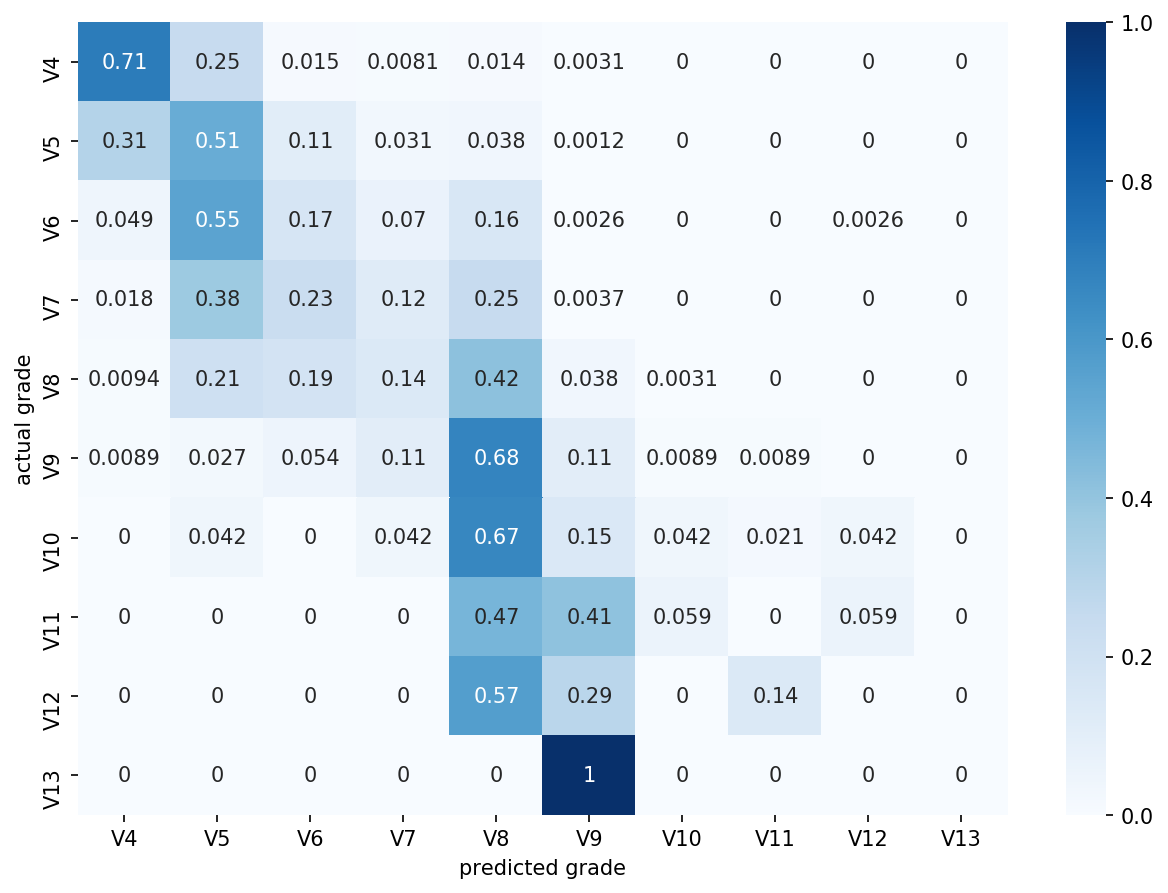

In [77]:
conf_matrix = confusion_matrix(Y_dev, models4.predict(X_dev).argmax(axis=1))
df_cm = pd.DataFrame((conf_matrix/np.sum(conf_matrix, axis = 1, keepdims = True)), 
                     index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(dpi = 150, figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('predicted grade')
plt.ylabel('actual grade')
plt.show()

In [118]:
models4.predict(X_dev)

array([[3.3850253e-02, 6.5167196e-02, 1.6822693e-01, ..., 1.3185669e-04,
        1.9864779e-05, 1.0605957e-04],
       [1.3519360e-01, 4.1901696e-01, 2.7990144e-01, ..., 1.0462324e-05,
        6.0331581e-07, 5.3379357e-05],
       [9.6783137e-01, 3.1987555e-02, 1.6476761e-04, ..., 3.8808315e-25,
        9.4090604e-18, 2.9378883e-10],
       ...,
       [9.9268132e-01, 7.3057781e-03, 1.1361599e-05, ..., 8.4342590e-32,
        3.0769943e-21, 5.7162122e-12],
       [8.0613121e-02, 2.0710962e-01, 2.2330941e-01, ..., 3.1279502e-03,
        4.2300281e-04, 9.4444072e-04],
       [8.4450912e-01, 1.5298159e-01, 2.3500447e-03, ..., 1.8020651e-18,
        1.0103177e-14, 6.8481527e-09]], dtype=float32)

In [117]:
F1_s4 = metrics.f1_score(Y_dev, models4.predict(X_dev), average = 'macro')
print(F1_s4)

ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

### model s5: change loss function

In [95]:
models5 = Sequential()
models5.add(Masking(mask_value=0., input_shape = (23, 22)))
models5.add(Dense(50, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models5.add(Dense(50, activation='relu', input_shape = (23, 50), kernel_initializer='glorot_normal'))
models5.add(Dense(50, activation='relu', input_shape = (23, 50), kernel_initializer='glorot_normal'))
models5.add(Dense(50, activation='relu', input_shape = (23, 50), kernel_initializer='glorot_normal'))
models5.add(Dense(50, activation='relu', input_shape = (23, 50), kernel_initializer='glorot_normal'))
models5.add(LSTM(50, activation='relu', input_shape=(23, 50), kernel_initializer='glorot_normal'))
models5.add(Dense(25, activation='relu', kernel_initializer='glorot_normal'))
models5.add(Dense(1, activation='relu', kernel_initializer='glorot_normal'))
opt = keras.optimizers.Adam(learning_rate=0.01)
models5.compile(optimizer = opt, loss=tf.keras.losses.MeanSquaredError())
print(models5.summary())

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_12 (Masking)         (None, 23, 22)            0         
_________________________________________________________________
dense_88 (Dense)             (None, 23, 50)            1150      
_________________________________________________________________
dense_89 (Dense)             (None, 23, 50)            2550      
_________________________________________________________________
dense_90 (Dense)             (None, 23, 50)            2550      
_________________________________________________________________
dense_91 (Dense)             (None, 23, 50)            2550      
_________________________________________________________________
dense_92 (Dense)             (None, 23, 50)            2550      
_________________________________________________________________
lstm_12 (LSTM)               (None, 50)              

In [96]:
historys5_all = []
np.random.seed(0)

In [97]:
for i in range(10):
    historys5 = models5.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data = (X_dev, Y_dev))
    historys5_all.append(historys5)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 7s 291us/step - loss: 1.8503 - val_loss: 1.2389
Epoch 2/10
24609/24609 [==============================] - 7s 270us/step - loss: 1.2103 - val_loss: 1.1910
Epoch 3/10
24609/24609 [==============================] - 7s 270us/step - loss: 1.1713 - val_loss: 1.2364
Epoch 4/10
24609/24609 [==============================] - 7s 275us/step - loss: 1.1792 - val_loss: 1.1622
Epoch 5/10
24609/24609 [==============================] - 7s 277us/step - loss: 1.1580 - val_loss: 1.2065
Epoch 6/10
24609/24609 [==============================] - 7s 275us/step - loss: 1.1335 - val_loss: 1.2523
Epoch 7/10
24609/24609 [==============================] - 8s 336us/step - loss: 1.1364 - val_loss: 1.1985
Epoch 8/10
24609/24609 [==============================] - 9s 374us/step - loss: 1.1105 - val_loss: 1.1285
Epoch 9/10
24609/24609 [==============================] - 7s 297us/step - loss: 1.1010 - val_loss: 1.14

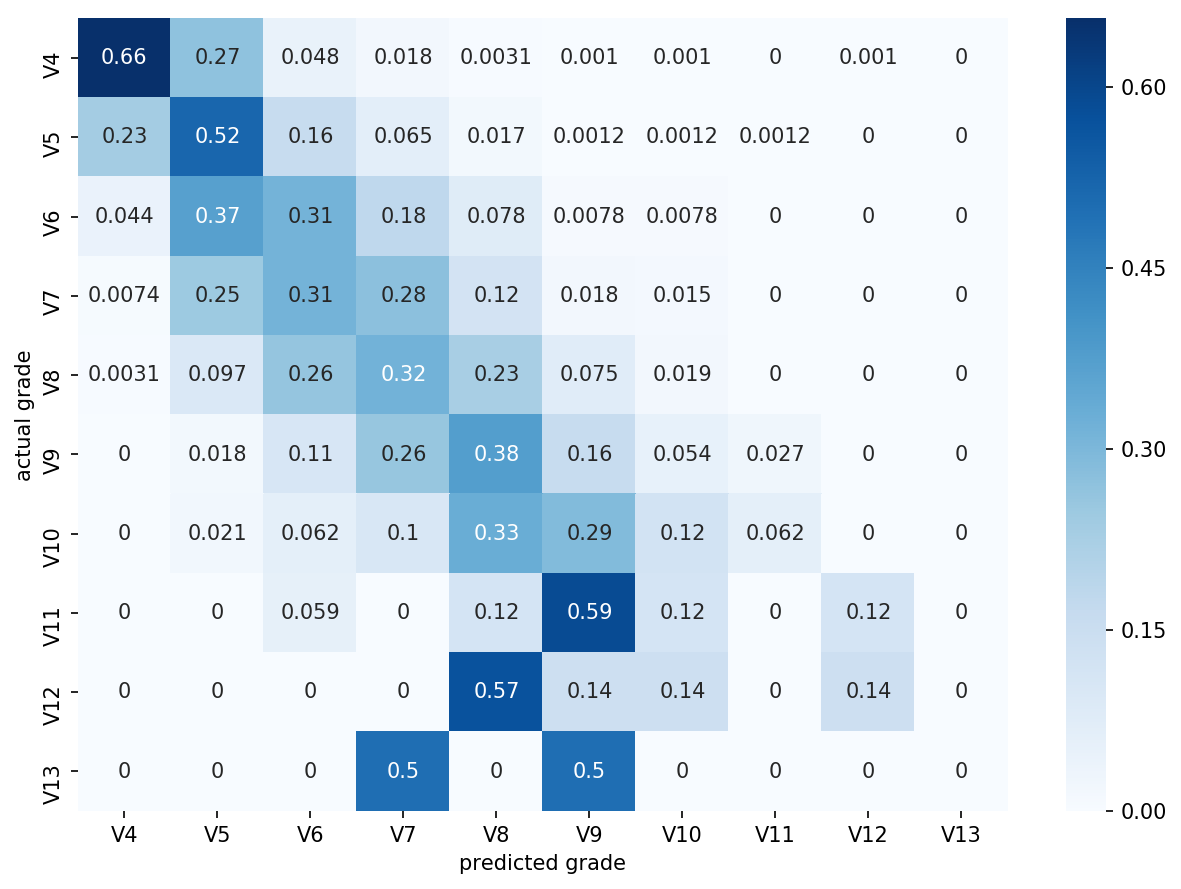

In [107]:
conf_matrix = confusion_matrix(Y_dev, np.round(models5.predict(X_dev)))
df_cm = pd.DataFrame((conf_matrix/np.sum(conf_matrix, axis = 1, keepdims = True)), 
                     index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(dpi = 150, figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('predicted grade')
plt.ylabel('actual grade')
plt.show()

In [113]:
np.sum(Y_dev == ))/3000

0.4613333333333333

In [114]:
from sklearn import metrics

In [116]:
F1_s5 = metrics.f1_score(Y_dev, np.round(models5.predict(X_dev).reshape((-1, ))), average = 'macro')
print(F1_s5)

0.25012389245729505


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### model S6

In [122]:
models6 = Sequential()
models6.add(Masking(mask_value=0., input_shape = (23, 22)))
models6.add(Dense(22, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models6.add(Dense(22, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models6.add(Dense(15, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models6.add(Dense(10, activation='relu', input_shape = (23, 15), kernel_initializer='glorot_normal'))
models6.add(Dense(10, activation='relu', input_shape = (23, 10), kernel_initializer='glorot_normal'))
models6.add(LSTM(10, activation='relu', input_shape=(23, 10), kernel_initializer='glorot_normal', return_sequences = True))
models6.add(LSTM(10, activation='relu', input_shape=(23, 10), kernel_initializer='glorot_normal', return_sequences = True))
models6.add(LSTM(10, activation='relu', input_shape=(23, 10), kernel_initializer='glorot_normal'))
models6.add(Dense(10, activation='relu', kernel_initializer='glorot_normal'))
models6.add(Dense(10, activation='relu', kernel_initializer='glorot_normal'))
models6.add(Dense(1, activation='relu', kernel_initializer='glorot_normal'))
opt = keras.optimizers.Adam(learning_rate=0.01)
models6.compile(optimizer = opt, loss=tf.keras.losses.MeanSquaredError())
print(models6.summary())

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_16 (Masking)         (None, 23, 22)            0         
_________________________________________________________________
dense_110 (Dense)            (None, 23, 22)            506       
_________________________________________________________________
dense_111 (Dense)            (None, 23, 22)            506       
_________________________________________________________________
dense_112 (Dense)            (None, 23, 15)            345       
_________________________________________________________________
dense_113 (Dense)            (None, 23, 10)            160       
_________________________________________________________________
dense_114 (Dense)            (None, 23, 10)            110       
_________________________________________________________________
lstm_18 (LSTM)               (None, 23, 10)          

In [123]:
historys6_all = []
np.random.seed(0)

In [124]:
for i in range(10):
    historys6 = models6.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data = (X_dev, Y_dev))
    historys6_all.append(historys6)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 7s 289us/step - loss: 2.0098 - val_loss: 1.2570
Epoch 2/10
24609/24609 [==============================] - 5s 207us/step - loss: 1.2165 - val_loss: 1.2967
Epoch 3/10
24609/24609 [==============================] - 5s 187us/step - loss: 1.2172 - val_loss: 1.2087
Epoch 4/10
24609/24609 [==============================] - 5s 194us/step - loss: 1.1908 - val_loss: 1.1882
Epoch 5/10
24609/24609 [==============================] - 5s 209us/step - loss: 1.1723 - val_loss: 1.2422
Epoch 6/10
24609/24609 [==============================] - 5s 222us/step - loss: 1.1590 - val_loss: 1.2342
Epoch 7/10
24609/24609 [==============================] - 7s 276us/step - loss: 1.1475 - val_loss: 1.1445
Epoch 8/10
24609/24609 [==============================] - 7s 280us/step - loss: 1.1305 - val_loss: 1.1536
Epoch 9/10
24609/24609 [==============================] - 6s 244us/step - loss: 1.1222 - val_loss: 1.17

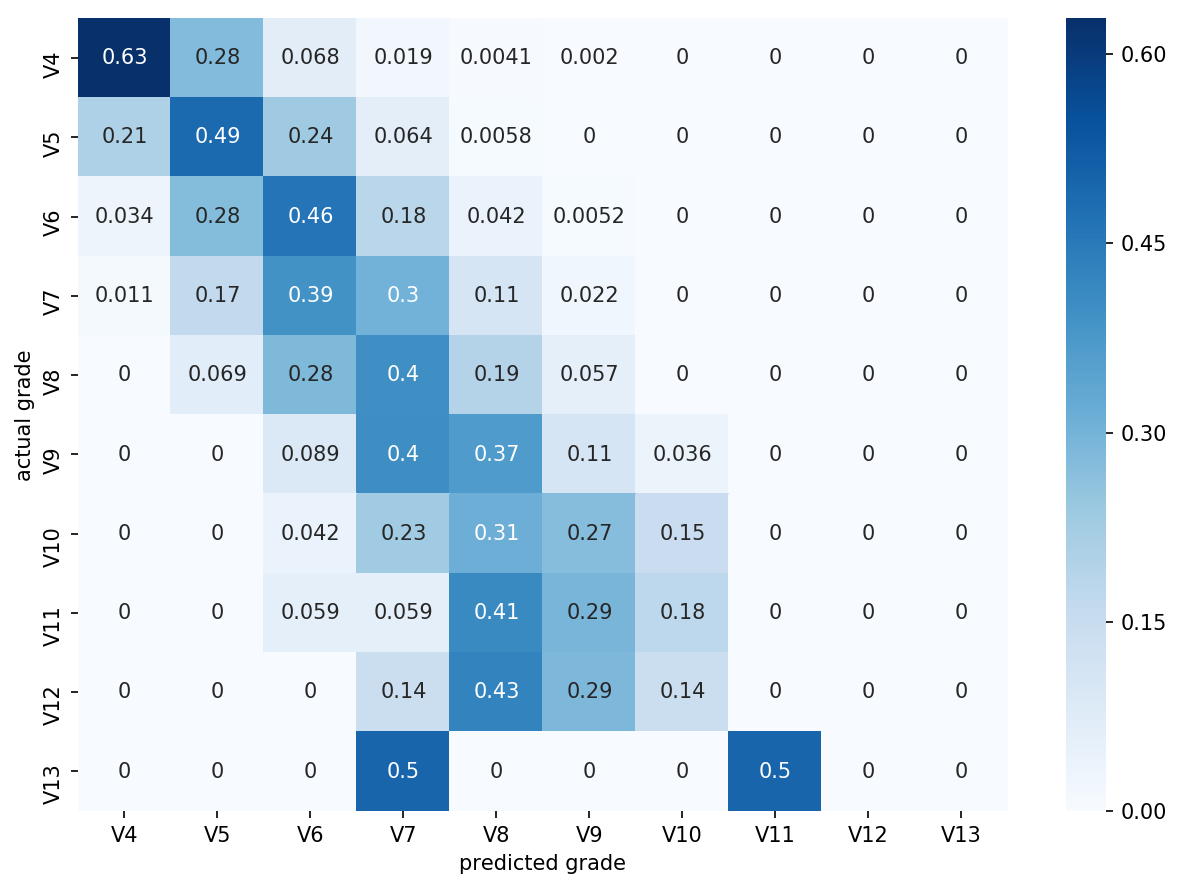

In [125]:
conf_matrix = confusion_matrix(Y_dev, np.round(models6.predict(X_dev)))
df_cm = pd.DataFrame((conf_matrix/np.sum(conf_matrix, axis = 1, keepdims = True)), 
                     index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(dpi = 150, figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('predicted grade')
plt.ylabel('actual grade')
plt.show()

In [126]:
F1_s6 = metrics.f1_score(Y_dev, np.round(models6.predict(X_dev).reshape((-1, ))), average = 'macro')
print(F1_s6)

0.23645816181466967


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### model S7: add max pooling

In [152]:
models7 = Sequential()
models7.add(Dense(22, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models7.add(Dense(22, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models7.add(Dense(15, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models7.add(Dense(10, activation='relu', input_shape = (23, 15), kernel_initializer='glorot_normal'))
models7.add(Dense(10, activation='relu', input_shape = (23, 10), kernel_initializer='glorot_normal'))
models7.add(LSTM(10, activation='relu', input_shape=(23, 10), kernel_initializer='glorot_normal', return_sequences = True))
models7.add(MaxPooling1D(pool_size = 2))
models7.add(LSTM(10, activation='relu', input_shape=(23, 10), kernel_initializer='glorot_normal', return_sequences = True))
models7.add(MaxPooling1D(pool_size = 2))
models7.add(LSTM(10, activation='relu', input_shape=(23, 10), kernel_initializer='glorot_normal', return_sequences = True))
models7.add(MaxPooling1D(pool_size = 2))
models7.add(Dense(10, activation='relu', kernel_initializer='glorot_normal'))
models7.add(Flatten())
models7.add(Dense(10, activation='relu', kernel_initializer='glorot_normal'))
models7.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
opt = keras.optimizers.Adam(learning_rate=0.01)
models7.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(models7.summary())

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_193 (Dense)            (None, 23, 22)            506       
_________________________________________________________________
dense_194 (Dense)            (None, 23, 22)            506       
_________________________________________________________________
dense_195 (Dense)            (None, 23, 15)            345       
_________________________________________________________________
dense_196 (Dense)            (None, 23, 10)            160       
_________________________________________________________________
dense_197 (Dense)            (None, 23, 10)            110       
_________________________________________________________________
lstm_49 (LSTM)               (None, 23, 10)            840       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 11, 10)          

In [153]:
historys7_all = []
np.random.seed(0)

In [154]:
for i in range(10):
    historys7 = models7.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data = (X_dev, Y_dev))
    historys7_all.append(historys7)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 4s 163us/step - loss: 1.4871 - accuracy: 0.3933 - val_loss: 1.3107 - val_accuracy: 0.4767
Epoch 2/10
24609/24609 [==============================] - 3s 106us/step - loss: 1.2973 - accuracy: 0.4641 - val_loss: 1.3010 - val_accuracy: 0.4730
Epoch 3/10
24609/24609 [==============================] - 3s 106us/step - loss: 1.2742 - accuracy: 0.4705 - val_loss: 1.2598 - val_accuracy: 0.4777
Epoch 4/10
24609/24609 [==============================] - 3s 112us/step - loss: 1.2640 - accuracy: 0.4685 - val_loss: 1.2693 - val_accuracy: 0.4723
Epoch 5/10
24609/24609 [==============================] - 3s 109us/step - loss: 1.2532 - accuracy: 0.4719 - val_loss: 1.2475 - val_accuracy: 0.4870
Epoch 6/10
24609/24609 [==============================] - 3s 104us/step - loss: 1.2491 - accuracy: 0.4730 - val_loss: 1.2554 - val_accuracy: 0.4757
Epoch 7/10
24609/24609 [==============================] - 3s 11

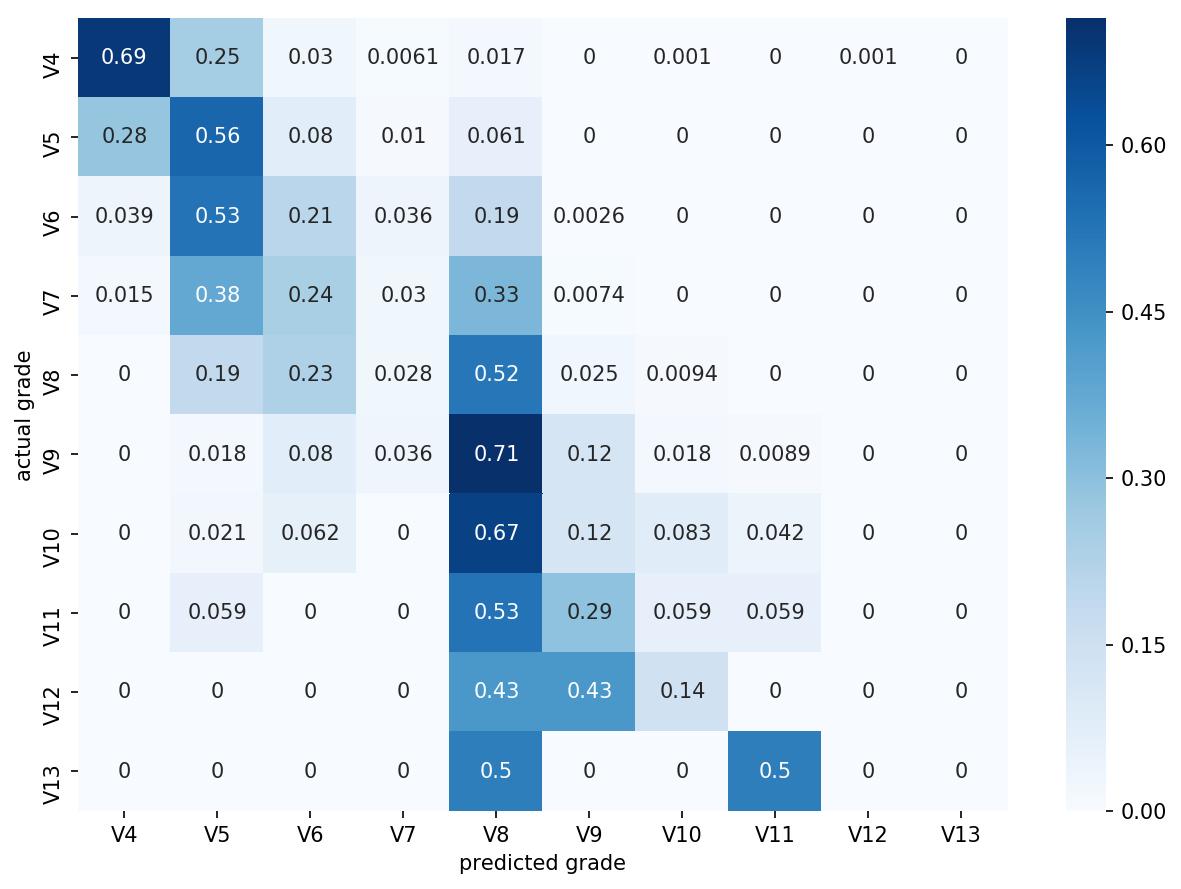

In [155]:
conf_matrix = confusion_matrix(Y_dev, models7.predict(X_dev).argmax(axis=1))
df_cm = pd.DataFrame((conf_matrix/np.sum(conf_matrix, axis = 1, keepdims = True)), 
                     index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(dpi = 150, figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('predicted grade')
plt.ylabel('actual grade')
plt.show()

In [159]:
F1_s7 = metrics.f1_score(Y_dev, models7.predict(X_dev).argmax(axis = 1), average = 'macro')
print(F1_s7)

0.22742991462298257


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### model s9: add masking back and more max pool

In [161]:
models9 = Sequential()
models9.add(Masking(mask_value=0., input_shape = (23, 22)))
models9.add(Dense(22, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models9.add(Dense(22, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models9.add(Dense(15, activation='relu', input_shape = (23, 22), kernel_initializer='glorot_normal'))
models9.add(Dense(10, activation='relu', input_shape = (23, 15), kernel_initializer='glorot_normal'))
models9.add(Dense(10, activation='relu', input_shape = (23, 10), kernel_initializer='glorot_normal'))
models9.add(LSTM(10, activation='relu', input_shape=(23, 10), kernel_initializer='glorot_normal', return_sequences = True))
models9.add(MaxPooling1D(pool_size = 2))
models9.add(LSTM(10, activation='relu', input_shape=(23, 10), kernel_initializer='glorot_normal', return_sequences = True))
models9.add(MaxPooling1D(pool_size = 2))
models9.add(LSTM(10, activation='relu', input_shape=(23, 10), kernel_initializer='glorot_normal', return_sequences = True))
models9.add(MaxPooling1D(pool_size = 2))
models9.add(Dense(10, activation='relu', kernel_initializer='glorot_normal'))
models9.add(Flatten())
models9.add(Dense(10, activation='relu', kernel_initializer='glorot_normal'))
models9.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))
opt = keras.optimizers.Adam(learning_rate=0.01)
models9.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(models9.summary())

TypeError: Layer max_pooling1d_23 does not support masking, but was passed an input_mask: Tensor("masking_23/Any_1:0", shape=(None, 23), dtype=bool)

### model s8: conv1D

In [136]:
models8 = Sequential()
models8.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(23, 22), kernel_initializer='glorot_normal'))
models8.add(MaxPooling1D(pool_size=2))
models8.add(Conv1D(filters=64, kernel_size=3, activation='relu', kernel_initializer='glorot_normal'))
models8.add(MaxPooling1D(pool_size=2))
models8.add(Flatten())
models8.add(Dense(100, activation='relu', kernel_initializer='glorot_normal'))
models8.add(Dense(10, activation='softmax'))
opt = keras.optimizers.Adam(learning_rate=0.01)
models8.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(models8.summary())

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 21, 64)            4288      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 10, 64)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 8, 64)             12352     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 4, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_150 (Dense)            (None, 100)               25700     
_________________________________________________________________
dense_151 (Dense)            (None, 10)              

In [137]:
historys8_all = []
np.random.seed(0)

In [138]:
for i in range(10):
    historys8 = models8.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data = (X_dev, Y_dev))
    historys8_all.append(historys8)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 2s 62us/step - loss: 1.3934 - accuracy: 0.4306 - val_loss: 1.2703 - val_accuracy: 0.4757
Epoch 2/10
24609/24609 [==============================] - 1s 46us/step - loss: 1.2574 - accuracy: 0.4784 - val_loss: 1.2897 - val_accuracy: 0.4647
Epoch 3/10
24609/24609 [==============================] - 1s 57us/step - loss: 1.2473 - accuracy: 0.4762 - val_loss: 1.2382 - val_accuracy: 0.4883
Epoch 4/10
24609/24609 [==============================] - 1s 51us/step - loss: 1.2330 - accuracy: 0.4817 - val_loss: 1.2389 - val_accuracy: 0.4820
Epoch 5/10
24609/24609 [==============================] - 1s 53us/step - loss: 1.2197 - accuracy: 0.4865 - val_loss: 1.2503 - val_accuracy: 0.4753
Epoch 6/10
24609/24609 [==============================] - 1s 47us/step - loss: 1.2071 - accuracy: 0.4926 - val_loss: 1.2615 - val_accuracy: 0.4777
Epoch 7/10
24609/24609 [==============================] - 1s 51us/ste

In [142]:
for i in range(10):
    historys8 = models8.fit(X_train, Y_train, epochs=10, batch_size=256, validation_data = (X_dev, Y_dev))
    historys8_all.append(historys8)

Train on 24609 samples, validate on 3000 samples
Epoch 1/10
24609/24609 [==============================] - 1s 53us/step - loss: 0.7765 - accuracy: 0.6730 - val_loss: 2.2983 - val_accuracy: 0.4413
Epoch 2/10
24609/24609 [==============================] - 1s 52us/step - loss: 0.7901 - accuracy: 0.6658 - val_loss: 2.3731 - val_accuracy: 0.4433
Epoch 3/10
24609/24609 [==============================] - 1s 53us/step - loss: 0.7813 - accuracy: 0.6676 - val_loss: 2.3521 - val_accuracy: 0.4393
Epoch 4/10
24609/24609 [==============================] - 1s 52us/step - loss: 0.7925 - accuracy: 0.6690 - val_loss: 2.3023 - val_accuracy: 0.4517
Epoch 5/10
24609/24609 [==============================] - 1s 45us/step - loss: 0.7807 - accuracy: 0.6702 - val_loss: 2.3496 - val_accuracy: 0.4503
Epoch 6/10
24609/24609 [==============================] - 1s 51us/step - loss: 0.7894 - accuracy: 0.6699 - val_loss: 2.4045 - val_accuracy: 0.4423
Epoch 7/10
24609/24609 [==============================] - 1s 48us/ste

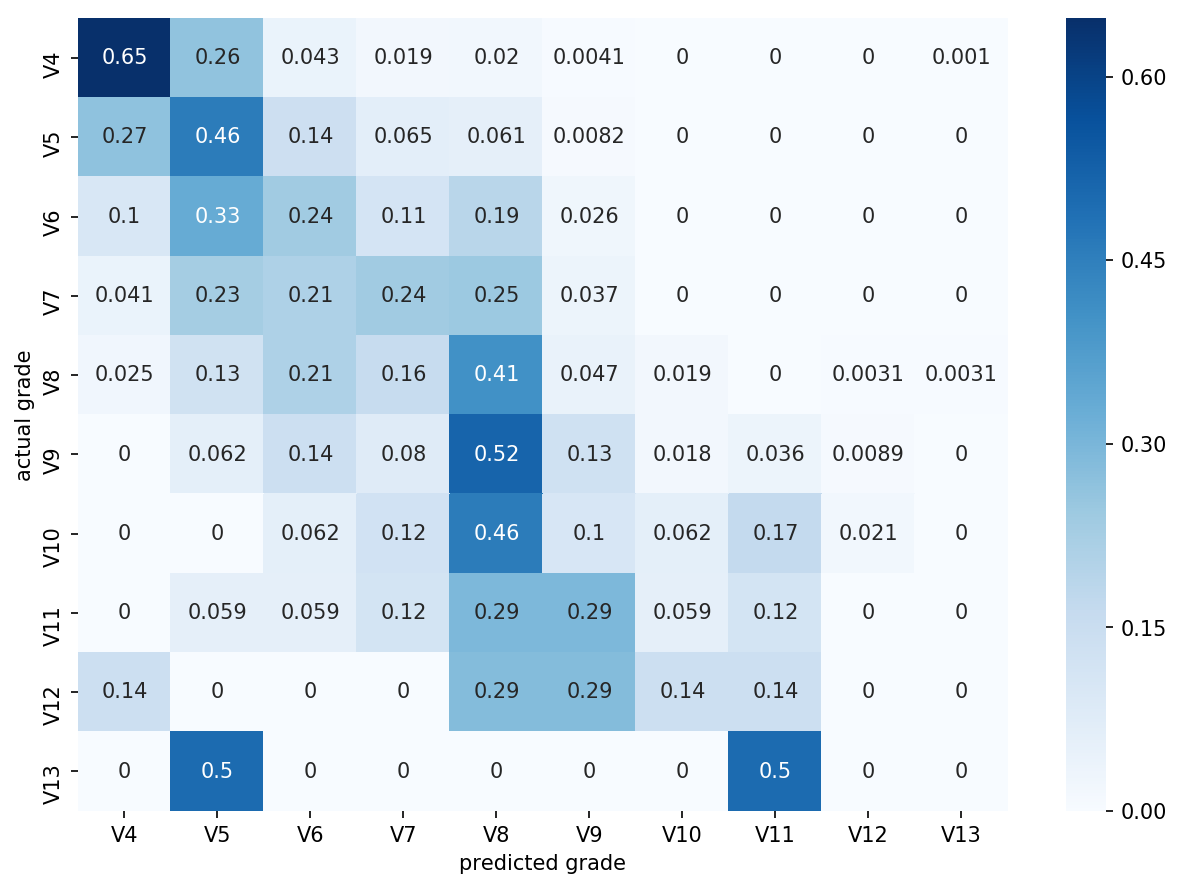

In [143]:
conf_matrix = confusion_matrix(Y_dev, models8.predict(X_dev).argmax(axis=1))
df_cm = pd.DataFrame((conf_matrix/np.sum(conf_matrix, axis = 1, keepdims = True)), 
                     index = [i for i in labels],
                     columns = [i for i in labels])
plt.figure(dpi = 150, figsize = (10,7))
sn.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.xlabel('predicted grade')
plt.ylabel('actual grade')
plt.show()

In [264]:
model_json = modelm5.to_json()
with open("modelm5.json", "w") as json_file:
    json_file.write(model_json)
modelm5.save_weights("modelm5.h5")

In [218]:
Y_dev_move.shape

(3000,)